# 1. Importing Depedendencies

Pada tahap ini dilakukan instalasi dan import dependencies yang dibutuhkan.

In [5]:
!pip install rdkit-pypi scikit-learn pandas
# !pip install dask[dataframe]
!conda install -c conda-forge openbabel -y
# !pip uninstall -y cffi
# !pip install --upgrade --force-reinstall cffi
# !pip install -q condacolab

  Using cached rdkit_pypi-2022.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
Using cached rdkit_pypi-2022.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.4 MB)
Retrieving notices: ...working... done
Channels:
 - conda-forge
 - rapidsai
 - nvidia
 - nodefaults
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openbabel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py310hff52083_0         895 KB  conda-forge
    openbabel-3.1.1            |  py310hbff9852_9         5.0 MB  conda-forge
    openssl-3.4.0              |       hb9d3cd8_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.7 MB

The following NEW pa

In [6]:
# import condacolab
import matplotlib.pyplot as plt
import numpy as np
import openbabel
import pandas as pd
import seaborn as sns
import warnings

In [7]:
from matplotlib.colors import Normalize
from matplotlib import cm
from openbabel import pybel
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, rdMolDescriptors
from tqdm.auto import tqdm

Inisiasi variabel beberapa fungsi dan nilai.

In [8]:
# Variabelized Functions
# condacolab.install()
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
plt.style.use('ggplot')
tqdm.pandas()
warnings.filterwarnings('ignore')

# Predefined Variable
rs = 666

# 2. Data Loading

Pada tahap ini dilakukan loading dataset dengan judul [SMILES Enumeation Datasets](https://github.com/summer-cola/SMILES-enumeration-datasets/blob/master/logS/trainset.csv)

In [9]:
url = 'https://raw.githubusercontent.com/summer-cola/SMILES-enumeration-datasets/refs/heads/master/logS/trainset.csv'
data = pd.read_csv(url)
data.loc[rs]

Unnamed: 0                                                   666
Compound ID                                                C2812
InChIKey                             ZTDIPPQFTNXLID-UHFFFAOYSA-N
SMILES         OC(=O)C(=O)O.CN(CC1COC2(O1)c1cc(Cl)ccc1OCc1c2c...
logS                                                   -5.336148
logP                                                      2.5661
MW                                                       435.855
smi            O C ( = O ) C ( = O ) O . C N ( C C 1 C O C 2 ...
Name: 666, dtype: object

Sampling data untuk masing-masing variabel

# 3. Data Understanding

Pada tahap ini dilakukan pemahaman fitur dataset serta fitur yang diekstrak.

## 3.1. Fitur Dataset

Pada tahap ini nama dan tipe data fitur dalam dataset diperhatikan.

In [10]:
ds = data.copy()
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7954 non-null   int64  
 1   Compound ID  7954 non-null   object 
 2   InChIKey     7954 non-null   object 
 3   SMILES       7954 non-null   object 
 4   logS         7954 non-null   float64
 5   logP         7954 non-null   float64
 6   MW           7954 non-null   float64
 7   smi          7954 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 497.2+ KB


Dataset memiliki 7954 data dengan tiga jenis data yaitu float64(3), int64(1), dan object(4). Numun, untuk kolom Unnamed: 0 merupakan kolom hasil export file csv sehingga hanya 7 kolom yang menyimpan data utama.

### 3.1.1. Deskripsi Variabel Dataset

Berikut merupakan deskripsi masing-masing variabel beserta contoh nilai-nilainya.

| Variabel | Deskripsi | Nilai |
| - | - | - |
| Unnamed: 0 | Indeks otomatis yang dihasilkan saat data diimpor. | 0 |
| Compound ID | ID unik untuk mengidentifikasi setiap senyawa dalam dataset. | C4659 |
| InChIKey | Kode alfanumerik yang merupakan versi singkat dari InChI (International Chemical Identifier) untuk identifikasi molekul unik secara global. | WIKXJKUZYYOTBP-UHFFFAOYSA-N |
| SMILES  | Simplified molecular input line entry system, bentuk notasi untuk deskripsi struktur molekul menggunakan *short ASCII strings*. | CCCCC(COC(=O)N)(COC(=O)NC(C)C)C |
| logS | Nilai logaritmik dari kelarutan dalam air (S), yang mengindikasikan seberapa larut suatu senyawa dalam air. | -3.633501683 |
| logP | Nilai logaritmik dari koefisien partisi oktanol-air (P), yang menunjukkan lipofilisitas atau kecenderungan senyawa untuk larut dalam lemak atau air. | 3.504 |
| MW  | Massa molekul (Molecular Weight), yaitu total massa atom dari molekul dalam satuan dalton (Da). | 274.357 |
| smi | Representasi alternative SMILES | C C C C C ( C O C ( = O ) N ) ( C O C ( = O ) N C ( C ) C ) C |


`Dataset` yang digunakan terlihat memiliki data `eksperimen` sebagai variabel penentu `sifat` suatu molekul dalam `Cheminformatics`. Terutama `LogS` yang merepresentasikan `Bioavailability` suatu molekul terutama dalam bidang `Drug Discoveries`.

Dari variabel-variabel yang disediakan datset, variabel yang selanjutnya digunakan dalam proyek kali ini adalah `SMILES` dan `LogS`, sementara `LogP` dan `MW` `eksperimen` akan digantikan oleh variable `teoritis` yang sama hasil descriptor dari `SMILES` pada tahap `Ekstraksi Fitur`.

### 3.1.2. Visualisasi Sederhana molekul dari SMILES.

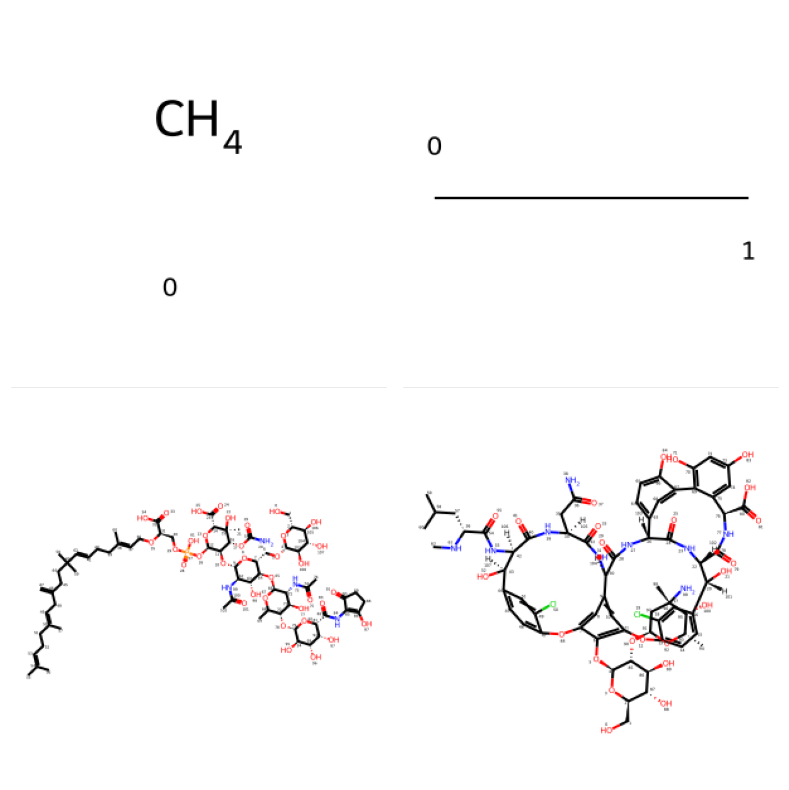

In [11]:
# Select 2 shortest and 2 longest SMILES based on length
longest_smiles_data = ds.assign(smiles_length=ds['SMILES'].str.len())
shortest_smiles_data = longest_smiles_data.nsmallest(2, 'smiles_length')
longest_smiles_data = longest_smiles_data.nlargest(2, 'smiles_length')
combined_data = pd.concat([shortest_smiles_data, longest_smiles_data])[['Compound ID', 'SMILES']]

# Plot the molecules in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for j, (i, row) in enumerate(combined_data.iterrows()):
    smiles = row['SMILES']
    compound_id = row['Compound ID']

    molecule = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(molecule, size=(300, 300), options=opts)

    axes[j].imshow(img)
    # axes[j].set_title(f'{compound_id}', fontsize=10, y=1.0, pad=-20)  # Compound ID as title
    axes[j].set_xticks([])
    axes[j].set_yticks([])

plt.tight_layout()
plt.show()


Visualisasi 4 molekul contoh dari `smiles` yang memiliki jumlah `str` terpendek dan terpanjang pada dataset dan dibandingkan dengan data yang tertera pada database [PubChem](https://pubchem.ncbi.nlm.nih.gov/). Karena `smiles` memiliki sifat *simplicity* dan *brevity* sehingga secara eksplisit menidakan sebagian besar atom `Hidrogen` dan hanya merepresentasikan molekul dalam bentuk `2D`. Penambahan atom `Hidrogen` dan operasi `Molecular Embedding` serta `Optimasi Geometri` diperlukan sebelum melakukan `3D deskriptor`. Langkah ini penting untuk memastikan representasi struktur geometri `3D` yang akurat dan ideal.

## 3.2. Ekstraksi Fitur

### 3.2.1. Konversi smiles menjadi notasi untuk molekul 3D

Pada tahap ini dilakukan generasi 3D molekul menggunakan optimasi `Mekanika Klasik`. Optimasi yang digunakan yaitu `MMFF94` (Merck molecular force field) dan `UFF` (Universal Force Field).`MMFF94` sangat `baik` dalam optmasi molekul organik sederhana namun memiliki range molekul yang `terbatas`, sehingga sebagai optimasi sekunder digunakan optimasi `UFF` yang berdara satu tingkat dibawah MMFF94 dan memiliki range molekul yang `luas`.

In [12]:
# Initialize counters
mmff94_count = 0
uff_count = 0
none_count = 0

# Function to convert SMILES to a 3D molecule using Open Babel
def rep_3D_openbabel(smiles):
    global mmff94_count, uff_count, none_count  # Reference global counters

    try:
        # Create an RDKit molecule from SMILES
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)  # Add hydrogen atoms

        # Convert RDKit molecule to Open Babel molecule
        mol_block = Chem.MolToMolBlock(mol)
        ob_mol = pybel.readstring("mol", mol_block)

        # Ensure hydrogens are present and generate 3D coordinates
        ob_mol.addh()
        ob_mol.make3D()

        # Try MMFF94 optimization; if unsuccessful, fall back to UFF
        ff = pybel._forcefields["mmff94"]
        if ff.Setup(ob_mol.OBMol):
            mmff94_count += 1
        else:
            ff = pybel._forcefields["uff"]
            if ff.Setup(ob_mol.OBMol):
                uff_count += 1
            else:
                none_count += 1
                print(f"Failed to set up force field for SMILES: {smiles}")
                return None

        # Run initial optimization, perform conformer search, and further optimize
        ff.ConjugateGradients(100, 1.0e-3)
        ff.WeightedRotorSearch(100, 25)
        ff.ConjugateGradients(250, 1.0e-4)

        # Update coordinates after optimization
        ff.GetCoordinates(ob_mol.OBMol)

        # Write to temporary file and load back into RDKit
        ob_mol.write("mol", "temp.mol", overwrite=True)
        optimized_mol = Chem.MolFromMolFile("temp.mol", sanitize=True, removeHs=False)

        return optimized_mol if optimized_mol is not None else None
    except Exception as e:
        none_count += 1
        print(f"Failed to process SMILES: {smiles} - Error: {e}")
        return None  # Return None if any error occurs

# Applying the function to a DataFrame column
tqdm.pandas()
ds['SMILES3d'] = ds['SMILES'].progress_apply(rep_3D_openbabel)

# Display optimization results
print()
print(f"MMFF94 optimizations: {mmff94_count}")
print(f"UFF optimizations: {uff_count}")
print(f"Failed optimizations: {none_count}")


  0%|          | 0/7954 [00:00<?, ?it/s]

*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 1 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 18
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 2 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 6 7
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 2 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 20 21
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 2 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 6 7
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 3 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 4 13 14
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 3 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 11 12 27
*** Open Babel Warning  in CorrectStereoAtoms
  Could not correct 4 stereocenter(s) in this molecule ()
  with Atom Ids as follows: 4 5 9 10
*** Open Babel Warning  in Correc


MMFF94 optimizations: 6746
UFF optimizations: 1208
Failed optimizations: 0


Proses optimasi telah berhasil dilalkukan. Degan total yang berhasil dioptimasi sebanyak `6746/1208` (MMFF94/UFF) molekul dan `0` molekul gagal dioprimasi.

In [13]:
ds3d = ds[ds['SMILES3d'].notna()]

Seluruh fitur yang **gagal** diekstrak menghasilkan nilai `None` dan dilakukan `notna()` sehingga data yang tersisa telah bersih dari `missing velue`.

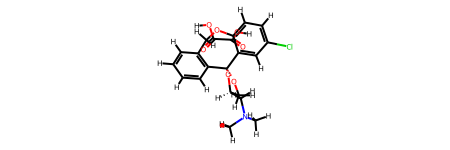

In [14]:
ds3d['SMILES3d'][rs]

Penambahan atom `Hidrogan` serta proses `Molecular Embedding` dan `Optimasi Geometri` **berhasil** dilakukan yang ditadai oleh adanya gugus `H` dan struktur dalam keadaan `3D`.

### 3.2.2. Ekstrakasi Fitur dari smiles Menggunakan Descriptor

Pada tahap ini dilakukan ekstraksi fitur menggunakan `Descriptor` tipe `OD`, `1D`, `2D`, dan `3D`.

In [15]:
def descriptors(mol: pd.DataFrame) -> pd.DataFrame:
    num_atoms = Descriptors.HeavyAtomCount(mol)
    num_carbons = len([atom for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6])
    num_non_carbons = num_atoms - num_carbons

    num_aromatic_atoms = len([atom for atom in mol.GetAtoms() if atom.GetIsAromatic()])
    aromatic_proportion = num_aromatic_atoms / num_atoms if num_atoms > 0 else 0

    non_carbon_proportion = num_non_carbons / num_atoms if num_atoms > 0 else 0

    descriptors = {
        # 0D
        'molWt': Descriptors.MolWt(mol),
        'numAtoms': num_atoms,
        'molMR' : Descriptors.MolMR(mol),
        # 1D
        'rings' : Descriptors.RingCount(mol),
        'aromatic' : Descriptors.NumAromaticRings(mol),
        'ap' : aromatic_proportion,
        'chiralC' : len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)),
        'logP': Descriptors.MolLogP(mol),
        'hbd' : Descriptors.NumHDonors(mol),
        'hba' : Descriptors.NumHAcceptors(mol),
        'rb' : Descriptors.NumRotatableBonds(mol),
        'tpsa' : Descriptors.TPSA(mol),
        'nh2' : len(mol.GetSubstructMatches(Chem.MolFromSmarts("N"))),
        'oh': len(mol.GetSubstructMatches(Chem.MolFromSmarts("[OX2H]"))),
        # 2D
        'balabanJ' : Descriptors.BalabanJ(mol),
        'bertzCT' : Descriptors.BertzCT(mol),
        'hallKierAlpha' : Descriptors.HallKierAlpha(mol),
        'ipc' : Descriptors.Ipc(mol),
        'chi0' : Descriptors.Chi0(mol),
        'chi1' : Descriptors.Chi1(mol),
        'kappa1' : Descriptors.Kappa1(mol),
        'kappa2' : Descriptors.Kappa2(mol),
        'kappa3' : Descriptors.Kappa3(mol),
        'fractionCSP3' : Descriptors.FractionCSP3(mol),
        # 3D
        'asphericity': rdMolDescriptors.CalcAsphericity(mol),
        'eccentricity': rdMolDescriptors.CalcEccentricity(mol),
        'inertialShapeFactor': rdMolDescriptors.CalcInertialShapeFactor(mol),
        'radiusOfGyration': rdMolDescriptors.CalcRadiusOfGyration(mol),
        'spherocityIndex': rdMolDescriptors.CalcSpherocityIndex(mol),
          # Proportions
          'ncp' : non_carbon_proportion,
          # Fingerprint
          'ecfp': list(map(int, AllChem.GetMorganFingerprintAsBitVect(mol, radius=4, nBits=2048).ToBitString()))
    }
    return pd.Series(descriptors)

descriptor_data = ds3d['SMILES3d'].progress_apply(descriptors)

  0%|          | 0/7954 [00:00<?, ?it/s]

Ekstraksi fitur menggunakan `Descriptor` tipe `OD`, `1D`, `2D`, dan `3D` **berhasil** dilakukan.
Berikut fitur-fitur beserta contoh masing-masing nilai-nya.

In [16]:
df_desc = pd.concat([ds3d['logS'], descriptor_data], axis=1)
df_desc.loc[rs]

logS                                                           -5.336148
molWt                                                             435.86
numAtoms                                                              30
molMR                                                           107.6566
rings                                                                  4
aromatic                                                               2
ap                                                                   0.4
chiralC                                                                2
logP                                                              2.5661
hbd                                                                    2
hba                                                                    8
rb                                                                     4
tpsa                                                              105.53
nh2                                                

Pada tahap ini keseluruhan fitur disimpan untuk kepentingan dokumentasi dan batch running.

In [17]:
df_desc.to_csv('Descripted_OpenBabel_MMFF94_UFF.csv', index=True)

### 3.2.2. Deskripsi Fitur Utama

Berikut merupakan deskripsi masing-masing fitur beserta nilai-nilainya.

| Variabel | Deskripsi | Nilai |
| - | - | - |
| logS | LogS, nilai logaritmik kelarutan molekul (terutama obat) dalam air | -2.74 |
| molWt | Molecule weight, berat molekul | 170.92 |
| numAtoms | Jumlah atom berat (selain hidrogen dalam molekul). | 8 |
| molMR | Molecular refractivity, kemampuan molekul untuk membiaskan cahaya, terkait dengan polarizabilitas molekul. |  21.6 |
| rings | Jumlah cincin dalam struktur molekul | 0 |
| aromatic | Jumlah cincin dengan sifat aromatik dalam molekul. | 0 |
| ap | Aromatic proportion, rasio atom aromatik terhadap total atom. | 0.0 |
| chiralC | Jumlah pusat kiral (Karbon) dalam molekul. | 0 |
| logP | Koefisien partisi logaritmik mengukur kepolaran molekul. | 2.6496 |
| hbd | Jumlah donor ikatan hidrogen | 0 |
| hba | Jumlah akseptor ikatan hidrogen | 0 |
| rb | Rotatable bond, umlah ikatan rotasi| 1 |
| tpsa | Topological polar surface area, luas permukaan molekul yang bersifat polar | 0.0 |
| nh2 |  Jumlah gugus amina | 0 |
| oh | Jumlah gugus hidroksil | 0 |
| balabanJ | Indeks Balaban (Balaban J Index), ukuran kekompakan topologi molekul. | 4.020392 |
| bertzCT | Kompleksitas topologi Bertz (Bertz CT), ukuran kerumitan molekul berdasarkan struktur graf. | 67.01955 |
| hallKierAlpha |  Indeks Hall-Kier Alpha, terkait dengan bentuk molekul dan polarizabilitasnya. | 0.3 |
| ipc | Indeks polaritas informasi (Information Content Index), mengukur keragaman struktur molekul. |  21.306059 |
| chi1 | Chi Path Index 0, pengukuran topologi molekul berdasarkan jumlah dan jenis atom. | 7.0 |
| chi2 | Chi Path Index 1, pengukuran jalur molekul berdasarkan pola ikatan atom. |  3.25 |
| kappa1 | Indeks kappa molekuler 1, mengukur fleksibilitas molekul. | 8.3 |
| kappa2 | Indeks kappa molekuler 2, variasi lain untuk mengukur fleksibilitas molekul. |  1.91511 |
| kappa3 | Indeks kappa molekuler 3, variasi lebih lanjut dari pengukuran fleksibilitas.| 2.046098 |
|fractionCSP3 | Fraksi atom karbon dalam hibridisasi sp3 | 1.0|
| asphericity |  Asferisitas, pengukuran penyimpangan bentuk molekul dari bentuk bola sempurna. | 0.072556 |
| eccentricity | Eksentrisitas, pengukuran asimetri dalam distribusi atom molekul. | 0.785158 |
| inertialShapeFactor | Faktor bentuk inersia, yang menunjukkan bentuk molekul berdasarkan distribusi massa atom. | 0.003042 |
| radiusOfGyration | Jari-jari perputaran (Radius of Gyration), mengukur penyebaran atom dalam molekul relatif terhadap pusat massa. | 1.836359 |
| spherocityIndex | Indeks sferisitas, yang menunjukkan seberapa dekat bentuk molekul dengan bola. | 0.711911 |
| ncp | Proporsi non-karbon terhadap total atom dalam molekul. | 0.75 |
| ecfp | Extended Circular Fingerprints, representasi molekul berbasis bit. | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... ] |


Berikut gambaran representasi `struktur` suatu molekul menjadi `Fingerprint ECFP`.

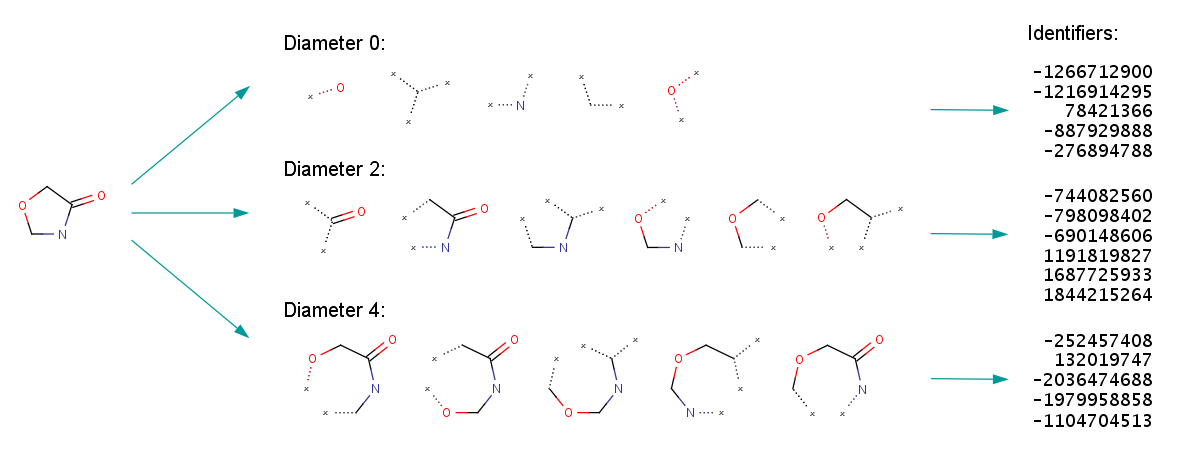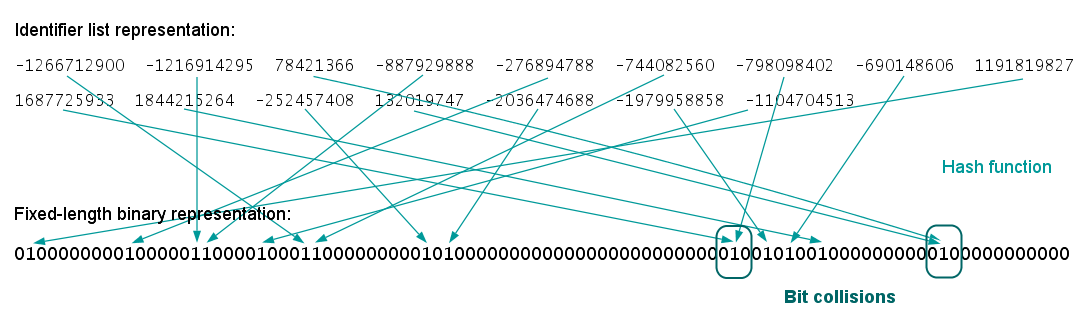